<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/gan%2Fpipeline/notebooks/Segmentation_Downstream_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation downstream task: SEN12FLOOD

Model: ResNetUnet \\
Data: SEN12FLOOD \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@gan/pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision gan/pipeline) to /tmp/pip-install-u0ljo01a/ssl-remote-sensing_e67372dae6e44aa49fa693588e882c90
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-u0ljo01a/ssl-remote-sensing_e67372dae6e44aa49fa693588e882c90
  Running command git checkout -b gan/pipeline --track origin/gan/pipeline
  Switched to a new branch 'gan/pipeline'
  Branch 'gan/pipeline' set up to track remote branch 'gan/pipeline' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 445 kB/s 
     |████████████████████████████████| 329 kB 71.2 MB/s 
     |████████████████████████████████| 1.9 MB 56.7 MB/s 
     |████████

In [2]:
!pip install rasterio torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# from ssl_remote_sensing.downstream_tasks.segmentatio
from ssl_remote_sensing.data.sen12floods_data import SEN12FLOODS
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

Downloading...
From: https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download
To: /content/lab-seg-data.tar.gz
100%|██████████| 5.37G/5.37G [00:40<00:00, 132MB/s]
/usr/local/lib/python3.7/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.7/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may 

In [5]:
import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score

In [6]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
RANDOM_INITIALIZATION

'random'

In [10]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = os.listdir(g_drive_path)
check_point_paths += [RANDOM_INITIALIZATION]
# check_point_paths.append(RANDOM_INITIALIZATION)
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_ResNet18_adam_bs2250-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/BiGAN_encoder_ckpt_100.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/random']

In [11]:
# for file in check_point_paths:
#   if file == '/content/drive/MyDrive/deep_learning_checkpoints/random':
#     print(file)

### Utils

In [12]:
# def display_outputs(idx=None, multi=False):
#     # Pick a random index if none is specified
#     if not idx:
#         idx = random.randint(0, len(valset))
#     print('Validation image ID: {}'.format(idx))
    
#     # Get Sentinel 2 and Sentinel 1 data
#     s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
#     s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
    
#     # Get predictions from the model
#     if multi:
#         output = model(s1_data, s2_data)
#     else:
#         output = model(s2_data)
    
#     # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
#     output_binary = torch.zeros(output.shape)
#     output_binary[output >= 0] = 1
    
#     get_metrics(valset.__getitem__(idx)['mask'], output_binary)
    
#     fig, axes = plt.subplots(1, 3, figsize=(15, 7))
#     axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3,2,1],:,:], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'].max())
#     axes[0].set_title('True Color Sentinel-2')
#     axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
#     axes[2].set_title('Groundtruth')
#     axes[1].imshow(output_binary.squeeze(), cmap='Blues')
#     axes[1].set_title('Predicted Mask')

### Hyperparameter setup

In [13]:
# Model Setup
class Hparams:
    def __init__(self):
        # self.pretext_task = "VAE"
        #self.pretext_task = "SimCLR"
        # self.pretext_saved_name = 'autoencoder.ckpt'
        self.checkpoint_name = None
        #self.pretext_saved_name = 'SimCLR_ResNet18_adam-v3.ckpt'
        self.epochs = 30 # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.save = "./saved_model"
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.latent_dim = 256
        self.optim = "Adam"
        self.embedding_size = 128  # papers value is 128
        self.temperature = 0.5  # 0.1 or 0.5
        self.weight_decay = 1e-6
        self.cuda = True  # use coda
        self.transform = False
        self.split = False

In [14]:
train_config = Hparams()

In [15]:
reproducibility(train_config)

### Directory & Wandb setup

## Data

SEN12FLOOD \\


*   13 Bands


In [16]:
trainset = SEN12FLOODS(
        root='/content/chips/',
        transforms=True,
        split='train')

valset = SEN12FLOODS(
    root='/content/chips/', 
    split='val')


train_loader = DataLoader(
    trainset,
    batch_size=8,
    pin_memory=True)

val_loader = DataLoader(
    valset,
    batch_size=8,
    pin_memory=True)

Found 688 images in the folder /content/chips/train
Found 211 images in the folder /content/chips/val


In [17]:
print("[LOG] Shape of mask image is:", next(iter(train_loader))["mask"].shape)
print("[LOG] Shape of sentinel-2 image is:", next(iter(train_loader))["s2_img"].shape)

[LOG] Shape of mask image is: torch.Size([8, 256, 256])
[LOG] Shape of sentinel-2 image is: torch.Size([8, 13, 256, 256])


/content/chips/train/8fcb3e59-7b1b-49c9-92c4-f4ddea14d4e4/s2/S2A_MSIL1C_20200805T085601_N0209_R007_T33MXU_20200805T112032_07168-08704
/content/chips/train/8fcb3e59-7b1b-49c9-92c4-f4ddea14d4e4/s1/S1A_IW_GRDH_1SDV_20200806T043438_20200806T043503_033781_03EA77_63A9_07168-08704


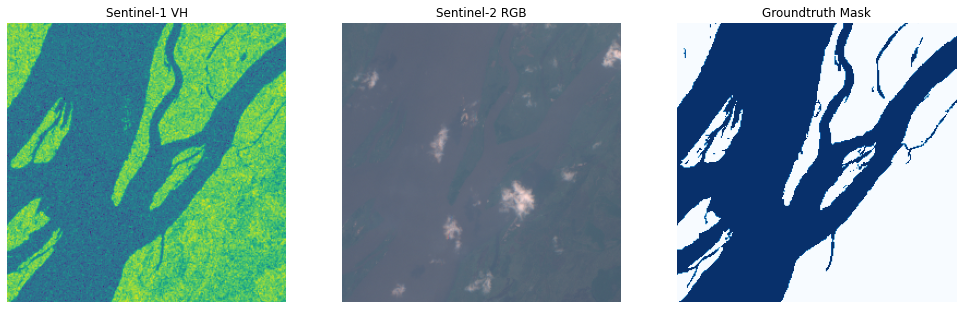

In [18]:
trainset.visualize_observation(196)

/content/chips/val/55d43c77-9955-4b4f-b6f0-b21e7f50a039/s2/S2A_MSIL1C_20190331T170901_N0207_R112_T14TQL_20190331T222948_07680-09728
/content/chips/val/55d43c77-9955-4b4f-b6f0-b21e7f50a039/s1/S1A_IW_GRDH_1SDV_20190404T002124_20190404T002149_026633_02FCE5_A8E7_07680-09728


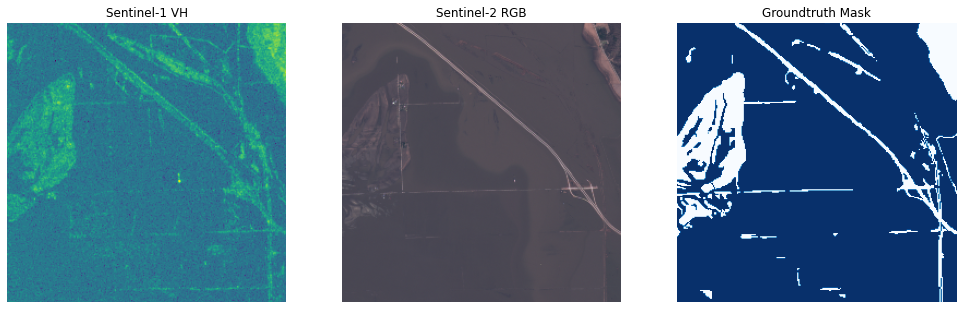

In [19]:
valset.visualize_observation(127)

/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s2/S2A_MSIL1C_20180920T095021_N0206_R079_T31PGM_20180920T115741_09638-09042
/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s1/S1A_IW_GRDH_1SDV_20180921T175422_20180921T175447_023800_0298AE_A9BF_09638-09042


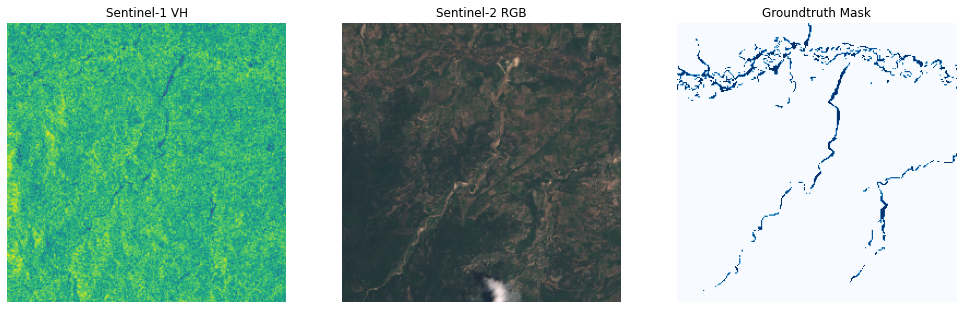

In [20]:
valset.visualize_observation(42)

/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s2/S2A_MSIL1C_20180920T095021_N0206_R079_T31PHK_20180920T115741_02792-04293
/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s1/S1A_IW_GRDH_1SDV_20180921T175357_20180921T175422_023800_0298AE_52A3_02792-04293


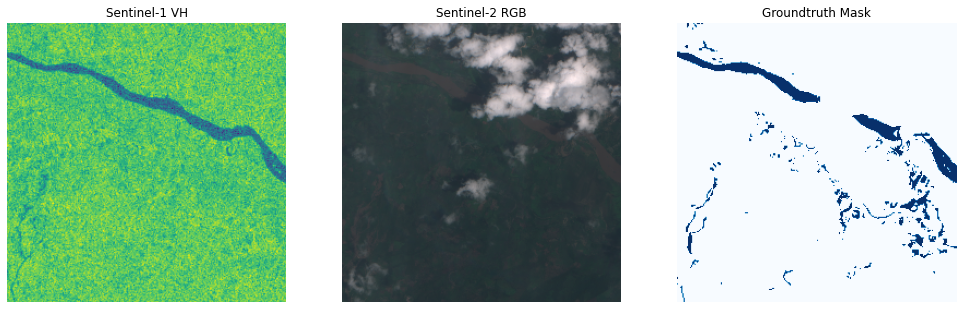

In [21]:
valset.visualize_observation(37)

## Model

In [22]:
# First of all, let's verify if a GPU is available on our compute machine. If not, the cpu will be used instead.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used: {}".format(device))
# Define a learning rate
learning_rate = train_config.lr
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

Device used: cuda:0


In [23]:
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

In [24]:
next(iter(train_loader))["s2_img"].shape

torch.Size([8, 13, 256, 256])

In [25]:
# load_encoder_checkpoint_from_pretext_model(
#         path_to_checkpoint='/content/drive/MyDrive/deep_learning_checkpoints/random'
#     )

In [26]:
# for file in check_point_paths:
#     print(file)
#     print(load_encoder_checkpoint_from_pretext_model(
#         path_to_checkpoint=file
#     ))

wandb: Currently logged in as: marccgrau (unisg-ds-nlp). Use `wandb login --relogin` to force relogin


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.5282: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


train_iou is 0.6153, val_iou is 0.4958
train_acc is 0.5349, val_acc is 0.5270


Validation Loss: 0.1763: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


Saving Model...
train_iou is 0.6984, val_iou is 0.7488
train_acc is 0.5425, val_acc is 0.5039


Validation Loss: 0.1977: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7208, val_iou is 0.7195
train_acc is 0.5437, val_acc is 0.5073


Validation Loss: 0.1300: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7198, val_iou is 0.7663
train_acc is 0.5494, val_acc is 0.5018


Validation Loss: 0.1291: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7346, val_iou is 0.7641
train_acc is 0.5487, val_acc is 0.5022


Validation Loss: 0.1569: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7319, val_iou is 0.7457
train_acc is 0.5449, val_acc is 0.5048


Validation Loss: 0.1354: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7416, val_iou is 0.7709
train_acc is 0.5432, val_acc is 0.5002


Validation Loss: 0.1454: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7257, val_iou is 0.7399
train_acc is 0.5462, val_acc is 0.5054


Validation Loss: 0.1388: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7310, val_iou is 0.7490
train_acc is 0.5496, val_acc is 0.5040


Validation Loss: 0.1297: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7384, val_iou is 0.7629
train_acc is 0.5469, val_acc is 0.5023


Validation Loss: 0.1304: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7493, val_iou is 0.7652
train_acc is 0.5469, val_acc is 0.5017


Validation Loss: 0.1570: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7296, val_iou is 0.7632
train_acc is 0.5420, val_acc is 0.5022


Validation Loss: 0.1184: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7463, val_iou is 0.7797
train_acc is 0.5460, val_acc is 0.4994


Validation Loss: 0.1229: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7627, val_iou is 0.7791
train_acc is 0.5465, val_acc is 0.4990


Validation Loss: 0.1142: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7608, val_iou is 0.7854
train_acc is 0.5442, val_acc is 0.4989


Validation Loss: 0.1219: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7651, val_iou is 0.7741
train_acc is 0.5463, val_acc is 0.4997


Validation Loss: 0.1157: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7488, val_iou is 0.7820
train_acc is 0.5450, val_acc is 0.4988


Validation Loss: 0.1199: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7615, val_iou is 0.7757
train_acc is 0.5469, val_acc is 0.4995


Validation Loss: 0.1129: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7562, val_iou is 0.7804
train_acc is 0.5468, val_acc is 0.4998


Validation Loss: 0.1096: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7699, val_iou is 0.7888
train_acc is 0.5454, val_acc is 0.4981


Validation Loss: 0.1155: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7695, val_iou is 0.7841
train_acc is 0.5466, val_acc is 0.4994


Validation Loss: 0.1190: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7772, val_iou is 0.7814
train_acc is 0.5461, val_acc is 0.4998


Validation Loss: 0.1175: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7752, val_iou is 0.7763
train_acc is 0.5457, val_acc is 0.5009


Validation Loss: 0.1125: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7669, val_iou is 0.7892
train_acc is 0.5467, val_acc is 0.4989


Validation Loss: 0.1201: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7700, val_iou is 0.7816
train_acc is 0.5467, val_acc is 0.5004


Validation Loss: 0.1335: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7687, val_iou is 0.7728
train_acc is 0.5478, val_acc is 0.5011


Validation Loss: 0.1424: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7703, val_iou is 0.7778
train_acc is 0.5428, val_acc is 0.5006


Validation Loss: 0.1058: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7745, val_iou is 0.8044
train_acc is 0.5447, val_acc is 0.4948


Validation Loss: 0.1142: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7874, val_iou is 0.7910
train_acc is 0.5446, val_acc is 0.4992


Validation Loss: 0.1063: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7821, val_iou is 0.8096
train_acc is 0.5431, val_acc is 0.4960
Finished Training
Sample image:  SimCLR_ResNet18_adam_bs2250-v1
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 0.999
Class 1 (water) accuracy: 0.479
Overall accuracy: 0.970
Equally Weighted accuracy: 0.739
IoU: 0.475
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.632
Class 1 (water) accuracy: 0.998
Overall accuracy: 0.950
Equally Weighted accuracy: 0.815
IoU: 0.945
*******************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▅▅██▆▅▆█▇▇▄▆▇▅▆▆▇▇▆▇▆▆▇▇▇▅▆▆▅
train_iou_segmentation,▁▄▅▅▆▆▆▅▆▆▆▆▆▇▇▇▆▇▇▇▇██▇▇▇▇▇██
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_segmentation,█▃▄▃▃▃▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁
val_iou_segmentation,▁▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇███
val_loss_segmentation,█▂▃▁▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
train_acc_segmentation,0.54313
train_iou_segmentation,0.7821
train_loss_segmentation,0.09863
val_acc_segmentation,0.49604
val_iou_segmentation,0.80957


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.1512: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.6227, val_iou is 0.7512
train_acc is 0.5285, val_acc is 0.5037


Validation Loss: 0.2428: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.6355, val_iou is 0.6976
train_acc is 0.5511, val_acc is 0.5091


Validation Loss: 0.2004: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7025, val_iou is 0.7231
train_acc is 0.5469, val_acc is 0.5068


Validation Loss: 0.1600: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7104, val_iou is 0.7012
train_acc is 0.5467, val_acc is 0.5093


Validation Loss: 0.2590: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7169, val_iou is 0.6947
train_acc is 0.5446, val_acc is 0.5101


Validation Loss: 0.3224: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7207, val_iou is 0.6889
train_acc is 0.5418, val_acc is 0.5104


Validation Loss: 0.1481: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7372, val_iou is 0.7601
train_acc is 0.5423, val_acc is 0.5036


Validation Loss: 0.2940: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7345, val_iou is 0.7266
train_acc is 0.5387, val_acc is 0.5068


Validation Loss: 0.2849: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7348, val_iou is 0.7056
train_acc is 0.5396, val_acc is 0.5092


Validation Loss: 0.1470: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7027, val_iou is 0.7623
train_acc is 0.5340, val_acc is 0.5000


Validation Loss: 0.1541: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7445, val_iou is 0.7537
train_acc is 0.5460, val_acc is 0.5038


Validation Loss: 0.1769: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7455, val_iou is 0.7246
train_acc is 0.5454, val_acc is 0.5072


Validation Loss: 0.1229: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7395, val_iou is 0.7875
train_acc is 0.5431, val_acc is 0.4986


Validation Loss: 0.2067: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7397, val_iou is 0.7178
train_acc is 0.5435, val_acc is 0.5076


Validation Loss: 0.1245: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7563, val_iou is 0.7757
train_acc is 0.5490, val_acc is 0.5019


Validation Loss: 0.2358: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7490, val_iou is 0.7115
train_acc is 0.5458, val_acc is 0.5083


Validation Loss: 0.1488: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7351, val_iou is 0.7585
train_acc is 0.5448, val_acc is 0.5034


Validation Loss: 0.1292: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7461, val_iou is 0.7772
train_acc is 0.5454, val_acc is 0.5020


Validation Loss: 0.1068: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7561, val_iou is 0.7882
train_acc is 0.5455, val_acc is 0.4998


Validation Loss: 0.1045: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7680, val_iou is 0.8007
train_acc is 0.5463, val_acc is 0.4978


Validation Loss: 0.1015: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7699, val_iou is 0.8008
train_acc is 0.5449, val_acc is 0.4973


Validation Loss: 0.1092: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7641, val_iou is 0.7938
train_acc is 0.5452, val_acc is 0.4990


Validation Loss: 0.1074: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7720, val_iou is 0.7926
train_acc is 0.5445, val_acc is 0.4990


Validation Loss: 0.1035: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7523, val_iou is 0.8211
train_acc is 0.5430, val_acc is 0.4909


Validation Loss: 0.4236: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7130, val_iou is 0.7413
train_acc is 0.5299, val_acc is 0.5047


Validation Loss: 0.1923: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.6402, val_iou is 0.7752
train_acc is 0.5295, val_acc is 0.4990


Validation Loss: 0.1774: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7339, val_iou is 0.7624
train_acc is 0.5354, val_acc is 0.5026


Validation Loss: 0.1182: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7591, val_iou is 0.7861
train_acc is 0.5428, val_acc is 0.4994


Validation Loss: 0.1444: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


train_iou is 0.7506, val_iou is 0.7885
train_acc is 0.5365, val_acc is 0.4867


Validation Loss: 0.1620: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7432, val_iou is 0.7590
train_acc is 0.5402, val_acc is 0.5030
Finished Training
Sample image:  vae
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 0.999
Class 1 (water) accuracy: 0.479
Overall accuracy: 0.970
Equally Weighted accuracy: 0.739
IoU: 0.475
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.694
Class 1 (water) accuracy: 0.996
Overall accuracy: 0.956
Equally Weighted accuracy: 0.845
IoU: 0.951
*******************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁█▇▇▆▅▅▄▄▃▆▆▆▆▇▆▆▆▆▇▆▆▆▅▁▁▃▅▃▅
train_iou_segmentation,▁▂▅▅▅▆▆▆▆▅▇▇▆▆▇▇▆▇▇████▇▅▂▆▇▇▇
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
val_acc_segmentation,▆█▇███▆▇█▅▆▇▅▇▅▇▆▆▅▄▄▅▅▂▆▅▆▅▁▆
val_iou_segmentation,▄▁▃▂▁▁▅▃▂▅▄▃▆▃▆▂▅▆▆▇▇▇▆█▄▆▅▆▆▅
val_loss_segmentation,▂▄▃▂▄▆▂▅▅▂▂▃▁▃▁▄▂▂▁▁▁▁▁▁█▃▃▁▂▂
train_acc_segmentation,0.54017
train_iou_segmentation,0.74321
train_loss_segmentation,0.14128
val_acc_segmentation,0.50299
val_iou_segmentation,0.75899


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.6050: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.6424, val_iou is 0.4485
train_acc is 0.5323, val_acc is 0.5310


Validation Loss: 0.2014: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7065, val_iou is 0.7393
train_acc is 0.5434, val_acc is 0.5051


Validation Loss: 0.1775: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Saving Model...
train_iou is 0.7387, val_iou is 0.7470
train_acc is 0.5464, val_acc is 0.5051


Validation Loss: 0.1843: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7221, val_iou is 0.7327
train_acc is 0.5496, val_acc is 0.5062


Validation Loss: 0.1863: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7238, val_iou is 0.7602
train_acc is 0.5465, val_acc is 0.5037


Validation Loss: 0.1717: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Saving Model...
train_iou is 0.7285, val_iou is 0.7581
train_acc is 0.5480, val_acc is 0.5048


Validation Loss: 0.1302: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Saving Model...
train_iou is 0.7464, val_iou is 0.7867
train_acc is 0.5471, val_acc is 0.5013


Validation Loss: 0.1383: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


train_iou is 0.7540, val_iou is 0.7792
train_acc is 0.5466, val_acc is 0.5023


Validation Loss: 0.1876: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7599, val_iou is 0.7543
train_acc is 0.5441, val_acc is 0.5045


Validation Loss: 0.1614: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7552, val_iou is 0.7689
train_acc is 0.5439, val_acc is 0.5029


Validation Loss: 0.1282: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7341, val_iou is 0.7878
train_acc is 0.5455, val_acc is 0.5006


Validation Loss: 0.1379: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7523, val_iou is 0.7844
train_acc is 0.5469, val_acc is 0.5015


Validation Loss: 0.1722: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7603, val_iou is 0.7521
train_acc is 0.5463, val_acc is 0.5055


Validation Loss: 0.1662: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7398, val_iou is 0.7619
train_acc is 0.5448, val_acc is 0.5043


Validation Loss: 0.1348: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7545, val_iou is 0.7815
train_acc is 0.5472, val_acc is 0.5026


Validation Loss: 0.1151: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7455, val_iou is 0.7971
train_acc is 0.5485, val_acc is 0.5005


Validation Loss: 0.1172: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7553, val_iou is 0.7944
train_acc is 0.5465, val_acc is 0.5014


Validation Loss: 0.1395: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7626, val_iou is 0.7726
train_acc is 0.5473, val_acc is 0.5039


Validation Loss: 0.1065: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7521, val_iou is 0.8084
train_acc is 0.5497, val_acc is 0.4995


Validation Loss: 0.1177: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7795, val_iou is 0.7955
train_acc is 0.5451, val_acc is 0.4999


Validation Loss: 0.1306: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7599, val_iou is 0.7775
train_acc is 0.5469, val_acc is 0.5016


Validation Loss: 0.1214: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7570, val_iou is 0.7886
train_acc is 0.5471, val_acc is 0.5000


Validation Loss: 0.1116: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7719, val_iou is 0.8000
train_acc is 0.5470, val_acc is 0.4986


Validation Loss: 0.1064: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7653, val_iou is 0.8076
train_acc is 0.5466, val_acc is 0.4980


Validation Loss: 0.1550: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7769, val_iou is 0.7631
train_acc is 0.5434, val_acc is 0.5033


Validation Loss: 0.1202: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7508, val_iou is 0.7910
train_acc is 0.5481, val_acc is 0.4997


Validation Loss: 0.1234: 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


train_iou is 0.7741, val_iou is 0.7890
train_acc is 0.5447, val_acc is 0.5005


Validation Loss: 0.1115: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7730, val_iou is 0.8018
train_acc is 0.5474, val_acc is 0.4991


Validation Loss: 0.1234: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7738, val_iou is 0.7932
train_acc is 0.5471, val_acc is 0.5002


Validation Loss: 0.1232: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7731, val_iou is 0.7950
train_acc is 0.5449, val_acc is 0.5005
Finished Training
Sample image:  BiGAN_encoder_ckpt_100
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.435
Overall accuracy: 0.967
Equally Weighted accuracy: 0.717
IoU: 0.431
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.704
Class 1 (water) accuracy: 0.998
Overall accuracy: 0.959
Equally Weighted accuracy: 0.851
IoU: 0.954
*******************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▅▇█▇▇▇▇▆▆▆▇▇▆▇█▇▇█▆▇▇▇▇▅▇▆▇▇▆
train_iou_segmentation,▁▄▆▅▅▅▆▇▇▇▆▇▇▆▇▆▇▇▇█▇▇█▇█▇████
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_segmentation,█▂▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▂▁▁▁▂▁▂▁▁▂
val_iou_segmentation,▁▇▇▇▇▇█▇▇▇██▇▇▇██▇██▇███▇█████
val_loss_segmentation,█▂▂▂▂▂▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
train_acc_segmentation,0.54491
train_iou_segmentation,0.77305
train_loss_segmentation,0.10589
val_acc_segmentation,0.50046
val_iou_segmentation,0.79502


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.1370: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.6460, val_iou is 0.7635
train_acc is 0.5421, val_acc is 0.5029


Validation Loss: 0.2189: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7137, val_iou is 0.6583
train_acc is 0.5456, val_acc is 0.5131


Validation Loss: 0.1583: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.7041, val_iou is 0.7270
train_acc is 0.5467, val_acc is 0.5066


Validation Loss: 0.2027: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7377, val_iou is 0.7017
train_acc is 0.5488, val_acc is 0.5092


Validation Loss: 0.2534: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7284, val_iou is 0.6989
train_acc is 0.5450, val_acc is 0.5095


Validation Loss: 0.1480: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7028, val_iou is 0.7689
train_acc is 0.5505, val_acc is 0.5016


Validation Loss: 0.1740: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7495, val_iou is 0.7392
train_acc is 0.5470, val_acc is 0.5055


Validation Loss: 0.1496: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7444, val_iou is 0.7436
train_acc is 0.5456, val_acc is 0.5051


Validation Loss: 0.1433: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7613, val_iou is 0.7518
train_acc is 0.5457, val_acc is 0.5049


Validation Loss: 0.2516: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7406, val_iou is 0.7196
train_acc is 0.5417, val_acc is 0.5073


Validation Loss: 0.1453: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7326, val_iou is 0.7598
train_acc is 0.5492, val_acc is 0.5030


Validation Loss: 0.1283: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Saving Model...
train_iou is 0.7632, val_iou is 0.7535
train_acc is 0.5484, val_acc is 0.5040


Validation Loss: 0.1281: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Saving Model...
train_iou is 0.7570, val_iou is 0.7573
train_acc is 0.5490, val_acc is 0.5039


Validation Loss: 0.1188: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Saving Model...
train_iou is 0.7600, val_iou is 0.7813
train_acc is 0.5474, val_acc is 0.5004


Validation Loss: 0.1335: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7700, val_iou is 0.7668
train_acc is 0.5492, val_acc is 0.5022


Validation Loss: 0.1208: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7657, val_iou is 0.7863
train_acc is 0.5459, val_acc is 0.4996


Validation Loss: 0.1161: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7424, val_iou is 0.7976
train_acc is 0.5471, val_acc is 0.4965


Validation Loss: 0.1236: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7637, val_iou is 0.7619
train_acc is 0.5470, val_acc is 0.5033


Validation Loss: 0.1342: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7652, val_iou is 0.7574
train_acc is 0.5477, val_acc is 0.5035


Validation Loss: 0.1168: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7757, val_iou is 0.7761
train_acc is 0.5482, val_acc is 0.5008


Validation Loss: 0.1194: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7711, val_iou is 0.7849
train_acc is 0.5473, val_acc is 0.4994


Validation Loss: 0.1206: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7766, val_iou is 0.7876
train_acc is 0.5476, val_acc is 0.4995


Validation Loss: 0.1157: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Saving Model...
train_iou is 0.7799, val_iou is 0.7920
train_acc is 0.5457, val_acc is 0.4984


Validation Loss: 0.1379: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7883, val_iou is 0.7799
train_acc is 0.5428, val_acc is 0.5013


Validation Loss: 0.1197: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7879, val_iou is 0.7872
train_acc is 0.5436, val_acc is 0.4997


Validation Loss: 0.1323: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7755, val_iou is 0.7763
train_acc is 0.5440, val_acc is 0.5012


Validation Loss: 0.1170: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7848, val_iou is 0.7816
train_acc is 0.5469, val_acc is 0.5005


Validation Loss: 0.1378: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7620, val_iou is 0.7671
train_acc is 0.5460, val_acc is 0.5029


Validation Loss: 0.1525: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7665, val_iou is 0.7724
train_acc is 0.5463, val_acc is 0.5013


Validation Loss: 0.1183: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


train_iou is 0.7344, val_iou is 0.7817
train_acc is 0.5455, val_acc is 0.4995
Finished Training
Sample image:  random
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 0.999
Class 1 (water) accuracy: 0.478
Overall accuracy: 0.970
Equally Weighted accuracy: 0.739
IoU: 0.474
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.698
Class 1 (water) accuracy: 0.997
Overall accuracy: 0.958
Equally Weighted accuracy: 0.848
IoU: 0.953
*******************************************


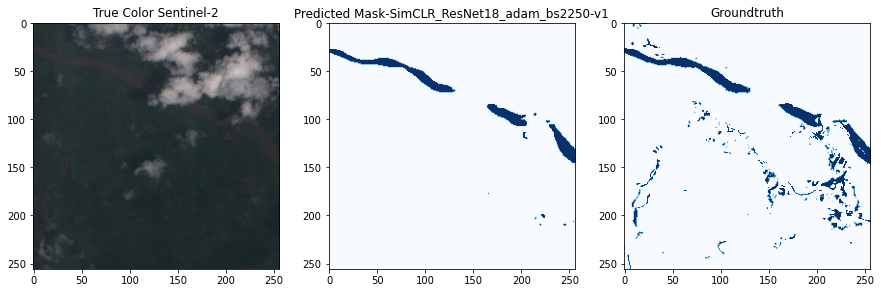

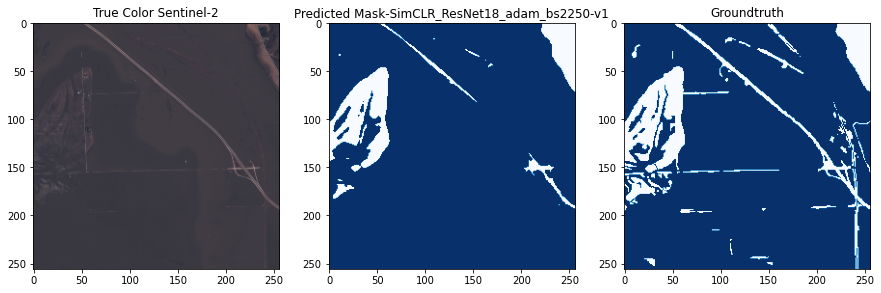

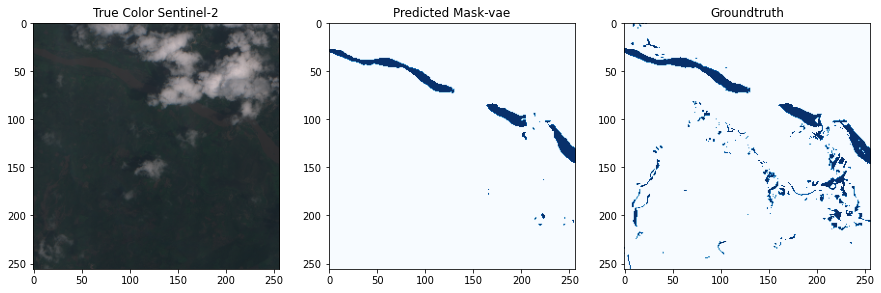

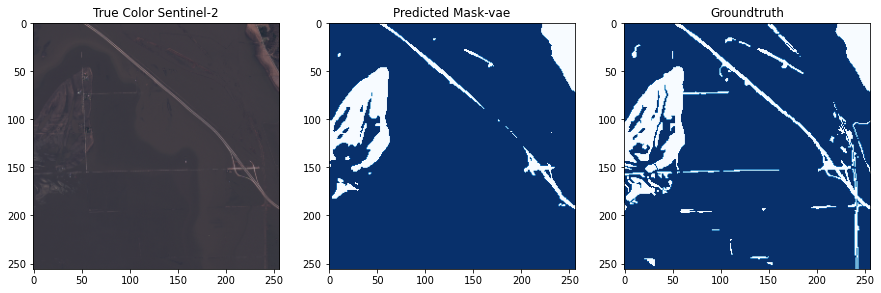

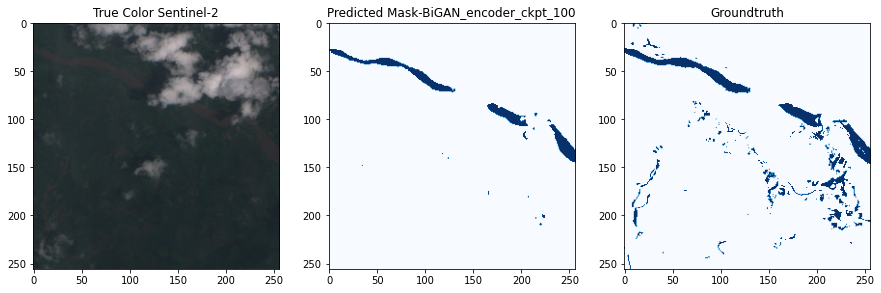

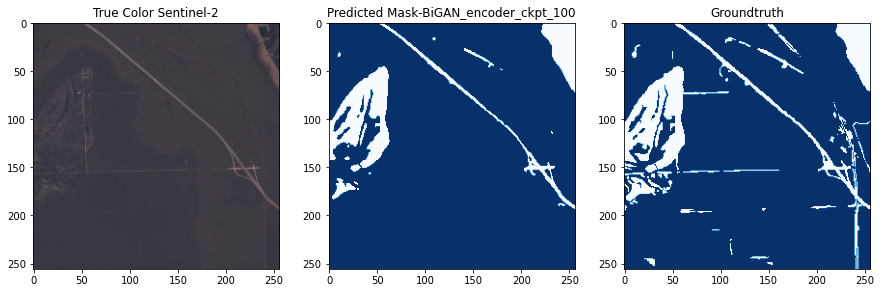

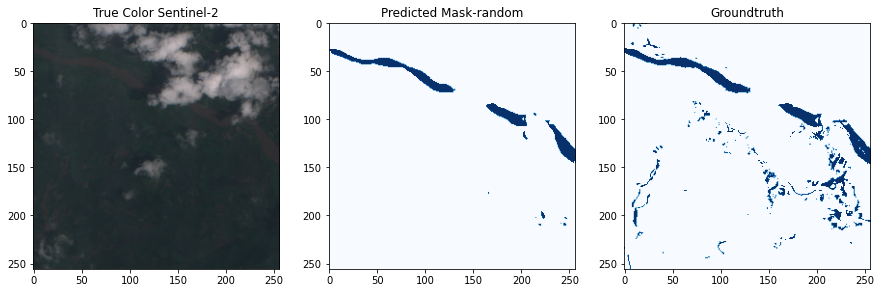

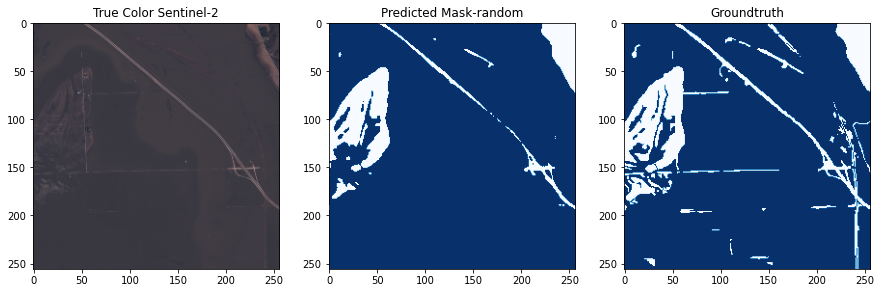

In [27]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    patch_first_conv(encoder,13,default_in_channels=3)

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
    model_path = os.path.join(model_dir,f'segmentation_{model_name}.ckpt')
    # make sure the directory path exists
    assert os.path.exists(model_dir)
    

    wandb.init(
        project="ssl-remote-sensing-segmentation",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(1,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(1, encoder = encoder, gan_encoder=False)

    # Initialise the optimizer
    if train_config.optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif train_config.optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epochs = train_config.epochs

    # Move the model to the GPU
    model.to(device)

    # Create lists for logging losses and evalualtion metrics:
    train_losses = []
    train_accs = []
    train_ious = []

    val_losses = []
    val_accs = []
    val_ious = []

    # IoU
    jaccard = JaccardIndex(num_classes=2).to(device)


    # For every epoch 
    for epoch in range(epochs):
        epoch_loss = 0
        progress = tqdm(
            enumerate(train_loader), desc="Train Loss: ",
            total=len(train_loader)
        )
        
        # Specify you are in training mode
        model.train()
        
        epoch_train_loss = 0
        epoch_val_loss = 0

        epoch_train_ious = 0
        epoch_val_ious = 0

        epoch_train_accs = 0
        epoch_val_accs = 0

        for i, batch in progress:
            # Transfer data to GPU if available
            data = batch["s2_img"].float().to(device)
            label = batch['mask'].float().to(device)
            
            # Make a forward pass
            output = model(data)
            #print(output.shape)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(train_loader)

            # Compute pixel accuracies
            epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
            
            # Compute the loss
            loss = criterion(output, label.unsqueeze(1))
            
            # Clear the gradients
            optimizer.zero_grad()

            # Calculate gradients 
            loss.backward()

            # Update Weights
            optimizer.step()
            
            # Accumulate the loss over the eopch
            epoch_train_loss += loss / len(train_loader)

            progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
                                        epoch_train_loss))

        progress = tqdm(
            enumerate(val_loader), desc="val Loss: ",
            total=len(val_loader), position=0, leave=True,)
        
        # Specify you are in evaluation mode
        model.eval()
        
        # Deactivate autograd engine (no backpropagation allowed)
        with torch.no_grad():
            epoch_val_loss = 0
            for j, batch in progress:
                # Transfer Data to GPU if available
                data = batch["s2_img"].float().to(device)
                label = batch['mask'].float().to(device)

                # Make a forward pass
                output = model(data)

                # Derive binary segmentation map from prediction
                output_binary = torch.zeros(output.shape)
                output_binary[output >= 0] = 1

                # Compute IoU
                epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(val_loader)

                # Compute pixel accuracies
                epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (len(val_loader) * (256*256) * 100)
                
                # Compute the loss
                val_loss = criterion(output, label.unsqueeze(1))
                        
                # Accumulate the loss over the epoch
                epoch_val_loss += val_loss / len(val_loader)

                progress.set_description("Validation Loss: {:.4f}".format(
                                        epoch_val_loss))
        
        if epoch == 0:
            best_val_loss = epoch_val_loss
        else:
            if epoch_val_loss <= best_val_loss:
                best_val_loss = epoch_val_loss
                # Save only the best model
                torch.save(model.state_dict(), model_path)
                print('Saving Model...')

        # save result to wandb
        wandb.log({'train_loss_segmentation': epoch_train_loss, 'val_loss_segmentation': epoch_val_loss, 
                  'train_iou_segmentation': epoch_train_ious, 'val_iou_segmentation':epoch_val_ious,
                   'train_acc_segmentation': epoch_train_accs, 'val_acc_segmentation':epoch_val_accs})

        # print("Epoch = ", epoch+1)
        # Save losses in list, so that we can visualise them later. 
        train_losses.append(epoch_train_loss.cpu().detach().numpy())
        val_losses.append(epoch_val_loss.cpu().detach().numpy())

        # Save IoUs in list, so that we can visualise them later. 
        train_ious.append(epoch_train_ious.cpu().detach().numpy())
        val_ious.append(epoch_val_ious.cpu().detach().numpy())
        print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

        # Save accuracies in list, so that we can visualise them later. 
        train_accs.append(epoch_train_accs.cpu().detach().numpy())
        val_accs.append(epoch_val_accs.cpu().detach().numpy())
        print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

    print('Finished Training')

    # Initialise a UNet() model 
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(1,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(1, encoder = encoder, gan_encoder=False)
    # Load pretrained weights
    model.load_state_dict(torch.load(model_path))
    # Move to device (GPU or CPU)
    model.to(device);

    def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
        if not idx:
            idx = random.randint(0, len(valset))
        print('Validation image ID: {}'.format(idx))
        
        # Get Sentinel 2 and Sentinel 1 data
        s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
        s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
        
        # Get predictions from the model
        if multi:
            output = model(s1_data, s2_data)
        else:
            output = model(s2_data)
        
        # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1
        
        get_metrics(valset.__getitem__(idx)['mask'], output_binary)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 7))
        axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3,2,1],:,:], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'].max())
        axes[0].set_title('True Color Sentinel-2')
        axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
        axes[2].set_title(f'Groundtruth')
        axes[1].imshow(output_binary.squeeze(), cmap='Blues')
        axes[1].set_title(f'Predicted Mask-{model_name}')

    print("Sample image: ", model_name)
    display_outputs(37)
    display_outputs(127)

Function copied from: https://github.com/qubvel/segmentation_models.pytorch